### Libraries

In [1]:
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.decomposition import PCA

#For 3D Plotting
import plotly.express as px

import pickle

### Importing Data

In [2]:
data = pd.read_csv("segmentation data.csv",index_col=0)

In [3]:
data.head()

Sex  Marital status  Age  Education  Income  Occupation  \
ID                                                                   
100000001    0               0   67          2  124670           1   
100000002    1               1   22          1  150773           1   
100000003    0               0   49          1   89210           0   
100000004    0               0   45          1  171565           1   
100000005    0               0   53          1  149031           1   

           Settlement size  
ID                          
100000001                2  
100000002                2  
100000003                0  
100000004                1  
100000005                1

In [4]:
data.describe()

Sex  Marital status          Age   Education         Income  \
count  2000.000000     2000.000000  2000.000000  2000.00000    2000.000000   
mean      0.457000        0.496500    35.909000     1.03800  120954.419000   
std       0.498272        0.500113    11.719402     0.59978   38108.824679   
min       0.000000        0.000000    18.000000     0.00000   35832.000000   
25%       0.000000        0.000000    27.000000     1.00000   97663.250000   
50%       0.000000        0.000000    33.000000     1.00000  115548.500000   
75%       1.000000        1.000000    42.000000     1.00000  138072.250000   
max       1.000000        1.000000    76.000000     3.00000  309364.000000   

        Occupation  Settlement size  
count  2000.000000      2000.000000  
mean      0.810500         0.739000  
std       0.638587         0.812533  
min       0.000000         0.000000  
25%       0.000000         0.000000  
50%       1.000000         1.000000  
75%       1.000000         1.000000  
max       2.000000         2.000000

### Calculating Correlation

In [5]:
data.corr()

Sex  Marital status       Age  Education    Income  \
Sex              1.000000        0.566511 -0.182885   0.244838 -0.195146   
Marital status   0.566511        1.000000 -0.213178   0.374017 -0.073528   
Age             -0.182885       -0.213178  1.000000   0.654605  0.340610   
Education        0.244838        0.374017  0.654605   1.000000  0.233459   
Income          -0.195146       -0.073528  0.340610   0.233459  1.000000   
Occupation      -0.202491       -0.029490  0.108388   0.064524  0.680357   
Settlement size -0.300803       -0.097041  0.119751   0.034732  0.490881   

                 Occupation  Settlement size  
Sex               -0.202491        -0.300803  
Marital status    -0.029490        -0.097041  
Age                0.108388         0.119751  
Education          0.064524         0.034732  
Income             0.680357         0.490881  
Occupation         1.000000         0.571795  
Settlement size    0.571795         1.000000

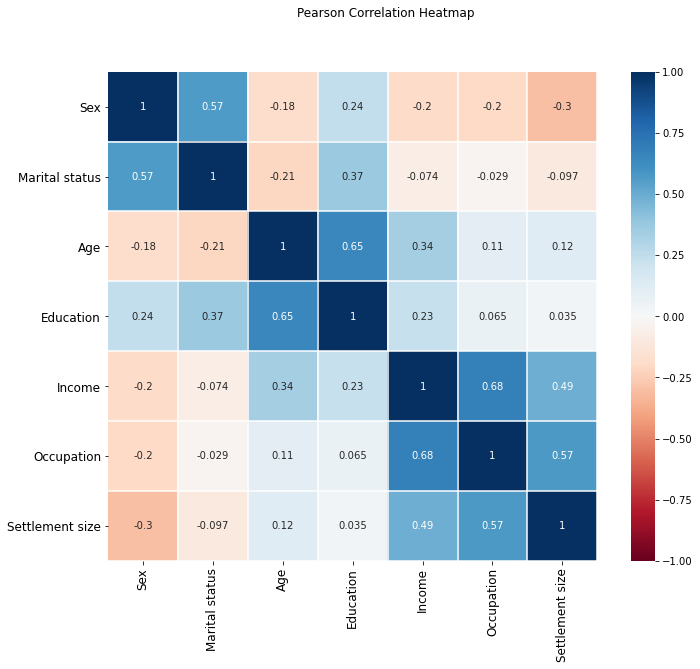

In [6]:
plt.figure(figsize = (12,9))
ax = sns.heatmap(data.corr(),square = True,annot = True,cmap = 'RdBu',vmin=-1,vmax=1)
plt.suptitle("Pearson Correlation Heatmap")
ax.set_yticklabels(ax.get_yticklabels(),rotation = 0,fontsize = 12)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90,fontsize = 12)

ax.vlines([1,2,3,4,5,6,7],*ax.get_ylim(),color = 'white')
ax.hlines([1,2,3,4,5,6,7],*ax.get_xlim(), color = 'white')
plt.show()

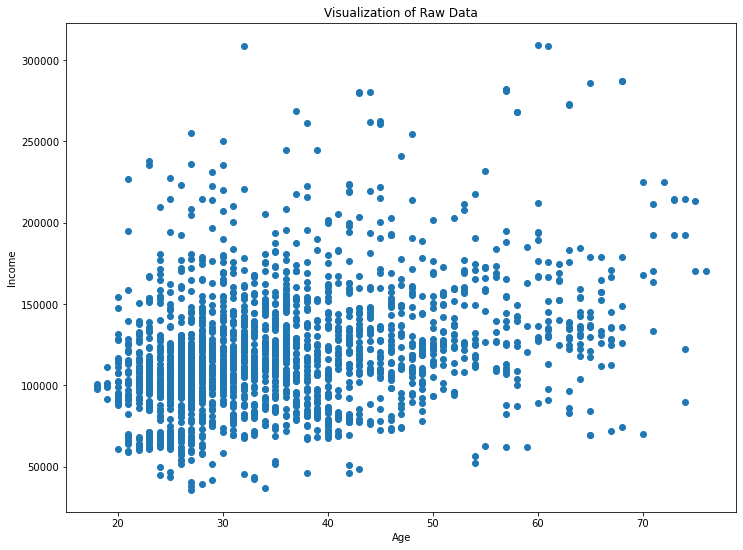

In [7]:
plt.figure(figsize = (12,9))
plt.scatter(data['Age'],data['Income'])
plt.xlabel("Age")
plt.ylabel("Income")
plt.title("Visualization of Raw Data")
plt.show()

### Standardizing and Clustering the Data

In [8]:
scaler = StandardScaler()
segmentation_std = scaler.fit_transform(data)

In [9]:
hier_clust = linkage(segmentation_std,method = 'ward')

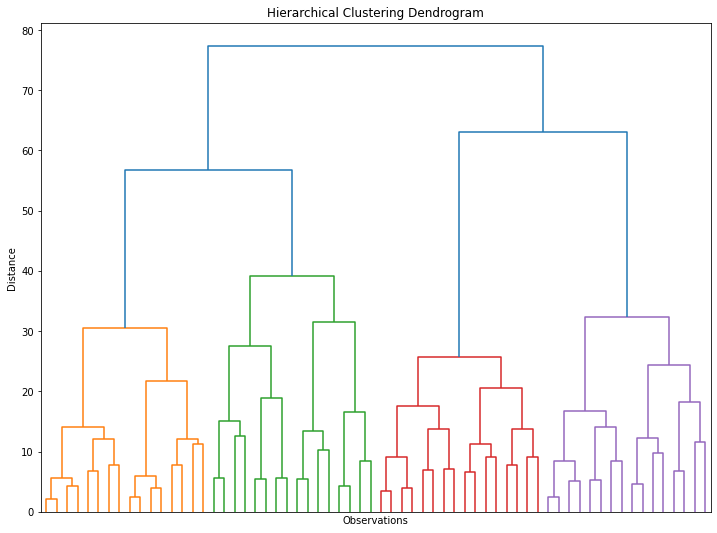

In [10]:
plt.figure(figsize = (12,9))
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hier_clust,
           truncate_mode="level",
           p=5,
          show_leaf_counts=False,
          no_labels= True)
plt.show()

In [11]:
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i,init = 'k-means++', random_state=59)
    kmeans.fit(segmentation_std)
    wcss.append(kmeans.inertia_)

### Using Elbow Method to get Optimal Clusters

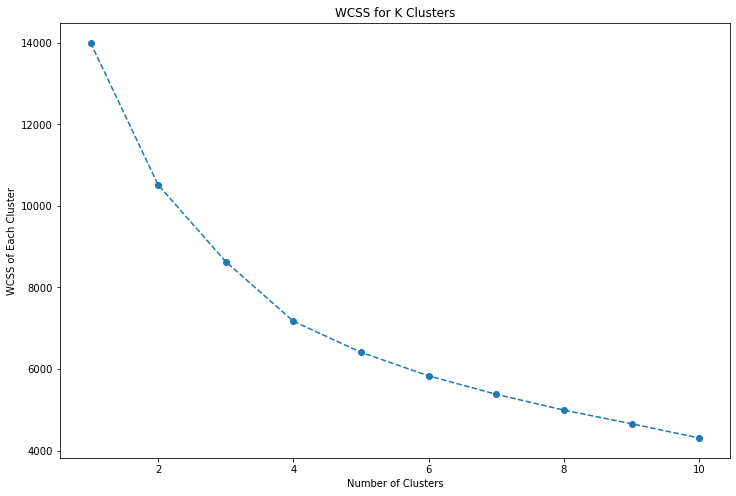

In [12]:
plt.figure(figsize = (12,8))
plt.plot(range(1,11),wcss,marker = 'o',linestyle = '--')
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS of Each Cluster")
plt.title("WCSS for K Clusters")
plt.show()

In [13]:
kmeans = KMeans(n_clusters=4,init="k-means++",random_state=73)

In [14]:
kmeans.fit(segmentation_std)

KMeans(n_clusters=4, random_state=73)

In [15]:
kmeans_seg_data = data.copy()
kmeans_seg_data['Segment k-means'] = kmeans.labels_

In [16]:
seg_data_analysis = kmeans_seg_data.groupby(['Segment k-means']).mean()
seg_data_analysis

Sex  Marital status        Age  Education  \
Segment k-means                                                   
0                0.352814        0.019481  35.577922   0.746753   
1                0.029825        0.173684  35.635088   0.733333   
2                0.853901        0.997163  28.963121   1.068085   
3                0.501901        0.692015  55.703422   2.129278   

                        Income  Occupation  Settlement size  
Segment k-means                                              
0                 97859.852814    0.329004         0.043290  
1                141218.249123    1.271930         1.522807  
2                105759.119149    0.634043         0.422695  
3                158338.422053    1.129278         1.110266

In [17]:
seg_data_analysis['N Obs'] = kmeans_seg_data[['Segment k-means','Sex']].groupby(['Segment k-means']).count()
seg_data_analysis['Proportion of Obs'] = seg_data_analysis['N Obs'] / seg_data_analysis['N Obs'].sum()
seg_data_analysis

Sex  Marital status        Age  Education  \
Segment k-means                                                   
0                0.352814        0.019481  35.577922   0.746753   
1                0.029825        0.173684  35.635088   0.733333   
2                0.853901        0.997163  28.963121   1.068085   
3                0.501901        0.692015  55.703422   2.129278   

                        Income  Occupation  Settlement size  N Obs  \
Segment k-means                                                      
0                 97859.852814    0.329004         0.043290    462   
1                141218.249123    1.271930         1.522807    570   
2                105759.119149    0.634043         0.422695    705   
3                158338.422053    1.129278         1.110266    263   

                 Proportion of Obs  
Segment k-means                     
0                           0.2310  
1                           0.2850  
2                           0.3525  
3                           0.1315

### labelling the Clusters of the Data

In [18]:
seg_data_analysis.rename({3:"Well-Off",
                        0:"Fewer Opporunities",
                        2:"Standard",
                        1:"Career-Focused"})

Sex  Marital status        Age  Education  \
Segment k-means                                                      
Fewer Opporunities  0.352814        0.019481  35.577922   0.746753   
Career-Focused      0.029825        0.173684  35.635088   0.733333   
Standard            0.853901        0.997163  28.963121   1.068085   
Well-Off            0.501901        0.692015  55.703422   2.129278   

                           Income  Occupation  Settlement size  N Obs  \
Segment k-means                                                         
Fewer Opporunities   97859.852814    0.329004         0.043290    462   
Career-Focused      141218.249123    1.271930         1.522807    570   
Standard            105759.119149    0.634043         0.422695    705   
Well-Off            158338.422053    1.129278         1.110266    263   

                    Proportion of Obs  
Segment k-means                        
Fewer Opporunities             0.2310  
Career-Focused                 0.2850  
Standard                       0.3525  
Well-Off                       0.1315

In [19]:
kmeans_seg_data['Labels'] = kmeans_seg_data['Segment k-means'].map({3:"Well-Off",
                        0:"Fewer Opporunities",
                        2:"Standard",
                        1:"Career-Focused"})

In [20]:
kmeans_seg_data.head()

Sex  Marital status  Age  Education  Income  Occupation  \
ID                                                                   
100000001    0               0   67          2  124670           1   
100000002    1               1   22          1  150773           1   
100000003    0               0   49          1   89210           0   
100000004    0               0   45          1  171565           1   
100000005    0               0   53          1  149031           1   

           Settlement size  Segment k-means              Labels  
ID                                                               
100000001                2                3            Well-Off  
100000002                2                2            Standard  
100000003                0                0  Fewer Opporunities  
100000004                1                1      Career-Focused  
100000005                1                1      Career-Focused

### Visualizing the Clusters

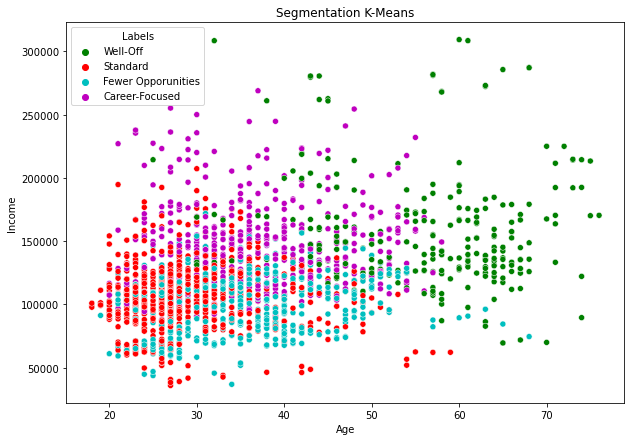

In [21]:
plt.figure(figsize = (10,7))
sns.scatterplot(x = 'Age',y = 'Income',data = kmeans_seg_data,hue = kmeans_seg_data['Labels'],palette=['g','r','c','m'])
plt.title("Segmentation K-Means")
plt.show()

### Using PCA for Dimensionality Reduction

In [22]:
pca = PCA()

In [23]:
pca.fit(segmentation_std)

PCA()

In [24]:
pca.explained_variance_ratio_

array([0.35696328, 0.26250923, 0.18821114, 0.0755775 , 0.05716512,
       0.03954794, 0.02002579])

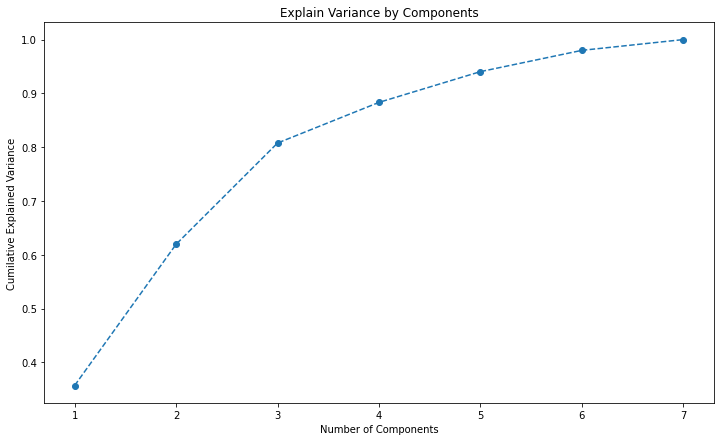

In [25]:
plt.figure(figsize=(12,7))
plt.plot(range(1,8), pca.explained_variance_ratio_.cumsum(), marker = 'o',linestyle = '--')
plt.title("Explain Variance by Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumilative Explained Variance")
plt.show()

In [26]:
pca = PCA(n_components=3)

In [27]:
pca.fit(segmentation_std)

PCA(n_components=3)

In [28]:
pca.explained_variance_ratio_

array([0.35696328, 0.26250923, 0.18821114])

### PCA Results


In [29]:
pca.components_

array([[-0.31469524, -0.19170439,  0.32609979,  0.15684089,  0.52452463,
         0.49205868,  0.46478852],
       [ 0.45800608,  0.51263492,  0.31220793,  0.63980683,  0.12468314,
         0.01465779, -0.06963165],
       [-0.29301261, -0.44197739,  0.60954372,  0.27560461, -0.16566231,
        -0.39550539, -0.29568503]])

In [30]:
data_pca = pd.DataFrame(data = pca.components_,
                       columns = data.columns.values,
                       index = ['Component 1 ','Component 2','Component 3'])
data_pca

Sex  Marital status       Age  Education    Income  \
Component 1  -0.314695       -0.191704  0.326100   0.156841  0.524525   
Component 2   0.458006        0.512635  0.312208   0.639807  0.124683   
Component 3  -0.293013       -0.441977  0.609544   0.275605 -0.165662   

              Occupation  Settlement size  
Component 1     0.492059         0.464789  
Component 2     0.014658        -0.069632  
Component 3    -0.395505        -0.295685

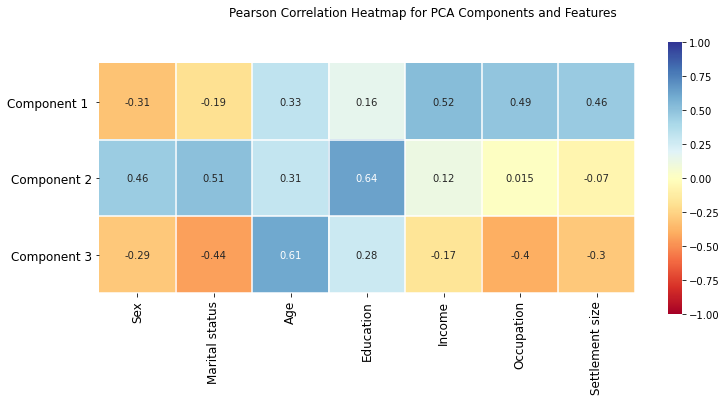

In [31]:
plt.figure(figsize = (12,5))
ax = sns.heatmap(data_pca,square = True,annot = True,cmap = 'RdYlBu',vmin=-1,vmax=1)
plt.suptitle("Pearson Correlation Heatmap for PCA Components and Features")
ax.set_yticklabels(ax.get_yticklabels(),rotation = 0,fontsize = 12)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90,fontsize = 12)

ax.vlines([1,2,3,4,5,6,7],*ax.get_ylim(),color = 'white')
ax.hlines([1,2,3,4,5,6,7],*ax.get_xlim(), color = 'white')
plt.show()


Component 1 - Shows Career of the Person <br>Component 2 - Shows Education and Lifestyle of a Person <br>Component 3 - Experience with no regard to Work or Career

In [32]:
pca.transform(segmentation_std)
#PCA Scores

array([[ 2.51474593,  0.83412239,  2.1748059 ],
       [ 0.34493528,  0.59814564, -2.21160279],
       [-0.65106267, -0.68009318,  2.2804186 ],
       ...,
       [-1.45229829, -2.23593665,  0.89657125],
       [-2.24145254,  0.62710847, -0.53045631],
       [-1.86688505, -2.45467234,  0.66262172]])

In [33]:
pca_scores = pca.transform(segmentation_std)

### K-Means with PCA


In [34]:
wcss = []
for i in range(1,11):
    kmeans_pca = KMeans(n_clusters=i,init = 'k-means++', random_state=59)
    kmeans_pca.fit(pca_scores)
    wcss.append(kmeans_pca.inertia_)

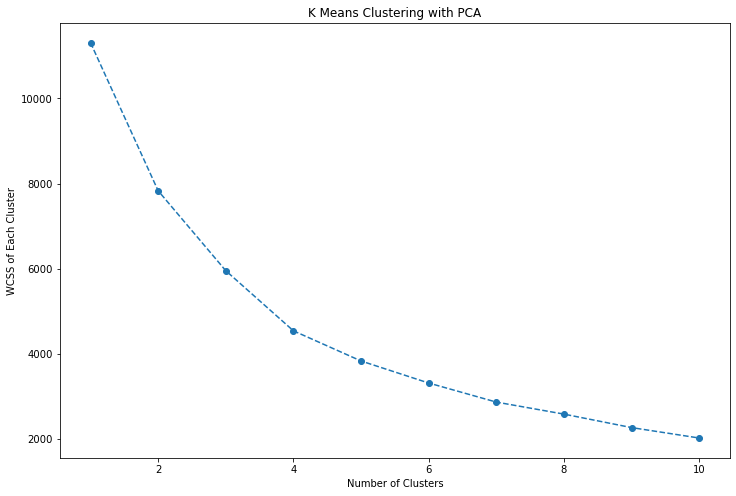

In [35]:
plt.figure(figsize = (12,8))
plt.plot(range(1,11),wcss,marker = 'o',linestyle = '--')
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS of Each Cluster")
plt.title("K Means Clustering with PCA")
plt.show()

In [36]:
kmeans_pca = KMeans(n_clusters = 4, init = 'k-means++', random_state = 71)

In [37]:
kmeans_pca.fit(pca_scores)

KMeans(n_clusters=4, random_state=71)

### K-Means Clustering with PCA Results

In [38]:
data_kmeans_pca = pd.concat([data.reset_index(drop=True), pd.DataFrame(pca_scores)], axis = 1)
data_kmeans_pca.columns.values[-3:] = ['Component 1','Component 2','Component 3']
data_kmeans_pca['Segment K-Means'] = kmeans_pca.labels_
data_kmeans_pca

Sex  Marital status  Age  Education  Income  Occupation  \
0       0               0   67          2  124670           1   
1       1               1   22          1  150773           1   
2       0               0   49          1   89210           0   
3       0               0   45          1  171565           1   
4       0               0   53          1  149031           1   
...   ...             ...  ...        ...     ...         ...   
1995    1               0   47          1  123525           0   
1996    1               1   27          1  117744           1   
1997    0               0   31          0   86400           0   
1998    1               1   24          1   97968           0   
1999    0               0   25          0   68416           0   

      Settlement size  Component 1  Component 2  Component 3  Segment K-Means  
0                   2     2.514746     0.834122     2.174806                3  
1                   2     0.344935     0.598146    -2.211603                1  
2                   0    -0.651063    -0.680093     2.280419                2  
3                   1     1.714316    -0.579927     0.730731                0  
4                   1     1.626745    -0.440496     1.244909                0  
...               ...          ...          ...          ...              ...  
1995                0    -0.866034     0.298330     1.438958                2  
1996                0    -1.114957     0.794727    -1.079871                1  
1997                0    -1.452298    -2.235937     0.896571                2  
1998                0    -2.241453     0.627108    -0.530456                1  
1999                0    -1.866885    -2.454672     0.662622                2  

[2000 rows x 11 columns]

In [39]:
data_kmeans_pca_freq = data_kmeans_pca.groupby(['Segment K-Means']).mean()
data_kmeans_pca_freq

Sex  Marital status        Age  Education  \
Segment K-Means                                                   
0                0.027444        0.168096  35.737564   0.734134   
1                0.900289        0.965318  28.878613   1.060694   
2                0.306522        0.095652  35.313043   0.760870   
3                0.505660        0.690566  55.679245   2.128302   

                        Income  Occupation  Settlement size  Component 1  \
Segment K-Means                                                            
0                141525.826758    1.267581         1.480274     1.372663   
1                107551.500000    0.677746         0.440751    -1.107019   
2                 93692.567391    0.252174         0.039130    -1.046406   
3                158019.101887    1.120755         1.101887     1.687328   

                 Component 2  Component 3  
Segment K-Means                            
0                  -1.046172    -0.248046  
1                   0.703776    -0.781410  
2                  -0.902963     1.003644  
3                   2.031200     0.844039

After analysing above table we can say that, <br>
Segment 0 is Career Focused<br>
Segment 1 is Standard<br>
Segment 2 is Fewer Opportunities<br>
Segment 3 is Well-off

In [40]:
data_kmeans_pca_freq['N Obs'] = data_kmeans_pca[['Segment K-Means','Sex']].groupby(['Segment K-Means']).count()
data_kmeans_pca_freq['Proportion of Obs'] = data_kmeans_pca_freq['N Obs'] / seg_data_analysis['N Obs'].sum()
data_kmeans_pca_freq = data_kmeans_pca_freq.rename({0:"Career Focused", 1:"Standard",2:"Fewer Opportunities",3:"Well-off"})

In [41]:
data_kmeans_pca_freq

Sex  Marital status        Age  Education  \
Segment K-Means                                                       
Career Focused       0.027444        0.168096  35.737564   0.734134   
Standard             0.900289        0.965318  28.878613   1.060694   
Fewer Opportunities  0.306522        0.095652  35.313043   0.760870   
Well-off             0.505660        0.690566  55.679245   2.128302   

                            Income  Occupation  Settlement size  Component 1  \
Segment K-Means                                                                
Career Focused       141525.826758    1.267581         1.480274     1.372663   
Standard             107551.500000    0.677746         0.440751    -1.107019   
Fewer Opportunities   93692.567391    0.252174         0.039130    -1.046406   
Well-off             158019.101887    1.120755         1.101887     1.687328   

                     Component 2  Component 3  N Obs  Proportion of Obs  
Segment K-Means                                                          
Career Focused         -1.046172    -0.248046    583             0.2915  
Standard                0.703776    -0.781410    692             0.3460  
Fewer Opportunities    -0.902963     1.003644    460             0.2300  
Well-off                2.031200     0.844039    265             0.1325

In [42]:
data_kmeans_pca['Legend'] = data_kmeans_pca['Segment K-Means'].map({0:"Career Focused", 1:"Standard",2:"Fewer Opportunities",3:"Well-off"})
data_kmeans_pca

Sex  Marital status  Age  Education  Income  Occupation  \
0       0               0   67          2  124670           1   
1       1               1   22          1  150773           1   
2       0               0   49          1   89210           0   
3       0               0   45          1  171565           1   
4       0               0   53          1  149031           1   
...   ...             ...  ...        ...     ...         ...   
1995    1               0   47          1  123525           0   
1996    1               1   27          1  117744           1   
1997    0               0   31          0   86400           0   
1998    1               1   24          1   97968           0   
1999    0               0   25          0   68416           0   

      Settlement size  Component 1  Component 2  Component 3  Segment K-Means  \
0                   2     2.514746     0.834122     2.174806                3   
1                   2     0.344935     0.598146    -2.211603                1   
2                   0    -0.651063    -0.680093     2.280419                2   
3                   1     1.714316    -0.579927     0.730731                0   
4                   1     1.626745    -0.440496     1.244909                0   
...               ...          ...          ...          ...              ...   
1995                0    -0.866034     0.298330     1.438958                2   
1996                0    -1.114957     0.794727    -1.079871                1   
1997                0    -1.452298    -2.235937     0.896571                2   
1998                0    -2.241453     0.627108    -0.530456                1   
1999                0    -1.866885    -2.454672     0.662622                2   

                   Legend  
0                Well-off  
1                Standard  
2     Fewer Opportunities  
3          Career Focused  
4          Career Focused  
...                   ...  
1995  Fewer Opportunities  
1996             Standard  
1997  Fewer Opportunities  
1998             Standard  
1999  Fewer Opportunities  

[2000 rows x 12 columns]

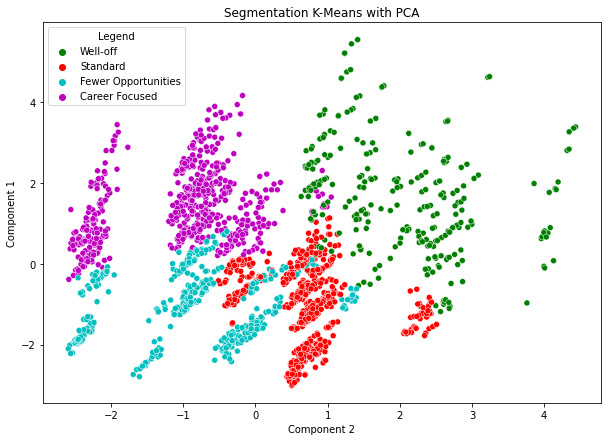

In [43]:
plt.figure(figsize = (10,7))
sns.scatterplot(x = 'Component 2',y = 'Component 1',data = data_kmeans_pca,hue = data_kmeans_pca['Legend'],palette=['g','r','c','m'])
plt.title("Segmentation K-Means with PCA")
plt.show()

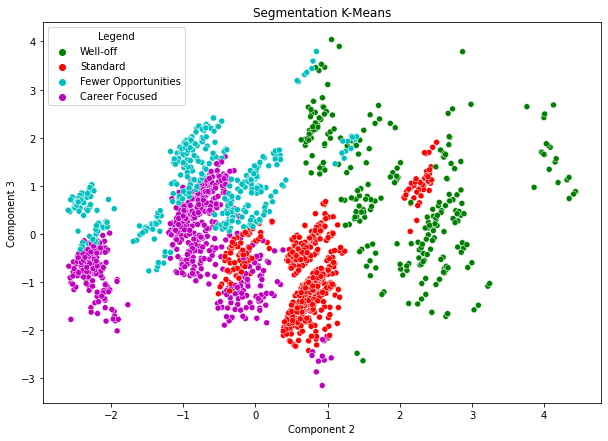

In [44]:
plt.figure(figsize = (10,7))
sns.scatterplot(x = 'Component 2',y = 'Component 3',data = data_kmeans_pca,hue = data_kmeans_pca['Legend'],palette=['g','r','c','m'])
plt.title("Segmentation K-Means")
plt.show()

In [45]:
fig = px.scatter_3d(data_kmeans_pca, x='Component 1', y='Component 2', z='Component 3',color='Legend')
fig.update_traces(marker=dict(size=9,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
#fig.write_html("clusters.html")
fig.show()

### Data Export 
We need these Pickle files for Data Preprocessing in Purchase Analytics

In [46]:
pickle.dump(scaler, open('scaler.pickle', 'wb'))
pickle.dump(pca, open('pca.pickle', 'wb'))
pickle.dump(kmeans_pca, open('kmeans_pca.pickle', 'wb'))